In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import os
import cv2
from PIL import Image
import copy
import time
import pickle


from tqdm.auto import tqdm
tqdm.pandas()

import glob

import torch
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler


from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayushsubedi","key":"3e35ef7e4ca7d5ebb110014575a431f4"}'}

In [3]:

!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

-rw-r--r-- 1 root root 67 Apr 29 02:04 kaggle.json


In [4]:
!kaggle datasets download ayushsubedi/cleannonstratifieddiabeticretinopathy

100% 12.1G/12.2G [03:18<00:00, 90.6MB/s]
100% 12.2G/12.2G [03:18<00:00, 65.9MB/s]


In [5]:
!unzip -qq /content/cleannonstratifieddiabeticretinopathy.zip

In [6]:
data_dir = '/content/content/dataset/cleannonstratifieddr'

In [11]:
loaded_model = torch.load('/content/drive/MyDrive/saved_models/24_inceptionnew.h5', map_location=torch.device('cpu'))
loaded_model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [12]:
class ben_color(object):
    def __call__(self, img, sigmaX=10):
        """
        :param img: PIL): Image 

        :return: Normalized image
        """

        img = np.asarray(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.crop_image_from_gray(img)
        img = cv2.resize(img, (input_size, input_size))
        img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)
        return Image.fromarray(img)

    def crop_image_from_gray(self, img, tol=7):
        if img.ndim ==2:
            mask = img>tol
            return img[np.ix_(mask.any(1),mask.any(0))]
        elif img.ndim==3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            mask = gray_img>tol
            
            check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
            if (check_shape == 0):
                return img 
            else:
                img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
                img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
                img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
                img = np.stack([img1,img2,img3],axis=-1)
            return img

    def __repr__(self):
        return self.__class__.__name__+'()'

In [13]:
def predict_image(image, test_transforms):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    _input = Variable(image_tensor)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    _input = _input.to(device)
    output = loaded_model(_input)
    x = output.data.cpu().numpy()[0]
    x = [float(i) for i in x]
    norm = [(i-min(x))/(max(x)-min(x)) for i in x]
    norm = [round(100*i/sum(norm), 2) for i in norm]
    pred = x.index(max(x))
    return norm



def transform_image(image_url):

    test_transforms = transforms.Compose([
        ben_color(),
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    image = Image.open(image_url)
    return predict_image(image, test_transforms)

In [14]:
input_size = 299
transform_image('/content/drive/MyDrive/data_2015_stratify/val/0/10151_right.jpg')

[46.45, 27.09, 22.97, 3.49, 0.0]

In [18]:
df_0 = pd.DataFrame(columns=['path', 'real'])
df_0['path'] = glob.glob("/content/content/dataset/cleannonstratifieddr/0/*.*")
df_0['real'] = 0

df_1 = pd.DataFrame(columns=['path', 'real'])
df_1['path'] = glob.glob("/content/content/dataset/cleannonstratifieddr/1/*.*")
df_1['real'] = 1

df_2 = pd.DataFrame(columns=['path', 'real'])
df_2['path'] = glob.glob("/content/content/dataset/cleannonstratifieddr/2/*.*")
df_2['real'] = 2

df_3 = pd.DataFrame(columns=['path', 'real'])
df_3['path'] = glob.glob("/content/content/dataset/cleannonstratifieddr/3/*.*")
df_3['real'] = 3

df_4 = pd.DataFrame(columns=['path', 'real'])
df_4['path'] = glob.glob("/content/content/dataset/cleannonstratifieddr/4/*.*")
df_4['real'] = 4

In [19]:
df = pd.concat([df_0, df_1, df_2, df_3, df_4])

In [ ]:
df

,path,real
0,/content/content/non_stratified_dr/0/41997_rig...,0
1,/content/content/non_stratified_dr/0/11232_rig...,0
2,/content/content/non_stratified_dr/0/39796_rig...,0
3,/content/content/non_stratified_dr/0/36575_rig...,0
4,/content/content/non_stratified_dr/0/2146_righ...,0
...,...,...
1292,/content/content/non_stratified_dr/4/17899_rig...,4
1293,/content/content/non_stratified_dr/4/7164_left...,4
1294,/content/content/non_stratified_dr/4/1707_righ...,4
1295,/content/content/non_stratified_dr/4/14226_rig...,4


In [20]:
df.real.value_counts()

0    48623
2     7770
1     2390
3     1508
4     1218
Name: real, dtype: int64

In [23]:
df.head(10).path.progress_apply(transform_image)

0     [56.8, 19.43, 22.61, 0.0, 1.17]
1    [52.15, 23.99, 19.09, 4.77, 0.0]
2    [60.65, 14.63, 18.83, 0.0, 5.88]
3     [45.06, 22.66, 26.2, 6.08, 0.0]
4    [55.08, 19.07, 24.18, 1.68, 0.0]
5    [48.27, 15.94, 31.04, 4.75, 0.0]
6     [53.68, 21.3, 22.23, 2.79, 0.0]
7    [49.53, 24.71, 21.05, 4.71, 0.0]
8     [57.67, 18.69, 20.34, 3.3, 0.0]
9     [54.26, 24.47, 17.2, 4.06, 0.0]
Name: path, dtype: object

In [24]:
df['preds'] = df.path.progress_apply(transform_image) 

In [76]:
df = pd.read_csv("/content/drive/MyDrive/inference (1).csv")

In [77]:
df

,path,real,preds
0,/content/content/dataset/cleannonstratifieddr/...,0,"[56.8, 19.43, 22.61, 0.0, 1.17]"
1,/content/content/dataset/cleannonstratifieddr/...,0,"[52.15, 23.99, 19.09, 4.77, 0.0]"
2,/content/content/dataset/cleannonstratifieddr/...,0,"[60.65, 14.63, 18.83, 0.0, 5.88]"
3,/content/content/dataset/cleannonstratifieddr/...,0,"[45.06, 22.66, 26.2, 6.08, 0.0]"
4,/content/content/dataset/cleannonstratifieddr/...,0,"[55.08, 19.07, 24.18, 1.68, 0.0]"
...,...,...,...
61504,/content/content/dataset/cleannonstratifieddr/...,4,"[0.0, 3.95, 18.14, 45.69, 32.22]"
61505,/content/content/dataset/cleannonstratifieddr/...,4,"[28.95, 12.27, 8.58, 0.0, 50.2]"
61506,/content/content/dataset/cleannonstratifieddr/...,4,"[17.66, 5.09, 0.0, 6.57, 70.68]"
61507,/content/content/dataset/cleannonstratifieddr/...,4,"[8.95, 0.0, 20.9, 17.76, 52.38]"


In [78]:
import ast
def str_to_list(string):
  return ast.literal_eval(string)

In [79]:
df['preds'] = df.preds.apply(str_to_list)

In [80]:
df_ = pd.DataFrame(df["preds"].to_list(), columns=[x for x in range(5)])

In [81]:
df_

,0,1,2,3,4
0,56.80,19.43,22.61,0.00,1.17
1,52.15,23.99,19.09,4.77,0.00
2,60.65,14.63,18.83,0.00,5.88
3,45.06,22.66,26.20,6.08,0.00
4,55.08,19.07,24.18,1.68,0.00
...,...,...,...,...,...
61504,0.00,3.95,18.14,45.69,32.22
61505,28.95,12.27,8.58,0.00,50.20
61506,17.66,5.09,0.00,6.57,70.68
61507,8.95,0.00,20.90,17.76,52.38


In [82]:
df = df.join(df_).drop("preds", axis=1)

In [84]:
df.to_csv("/content/drive/MyDrive/inference.csv", index=False)

In [85]:
df['predicted'] = df.iloc[:, 2:].idxmax(axis=1)
df['predicted'] = pd.to_numeric(df.predicted)

In [86]:
df

,path,real,0,1,2,3,4,predicted
0,/content/content/dataset/cleannonstratifieddr/...,0,56.80,19.43,22.61,0.00,1.17,0
1,/content/content/dataset/cleannonstratifieddr/...,0,52.15,23.99,19.09,4.77,0.00,0
2,/content/content/dataset/cleannonstratifieddr/...,0,60.65,14.63,18.83,0.00,5.88,0
3,/content/content/dataset/cleannonstratifieddr/...,0,45.06,22.66,26.20,6.08,0.00,0
4,/content/content/dataset/cleannonstratifieddr/...,0,55.08,19.07,24.18,1.68,0.00,0
...,...,...,...,...,...,...,...,...
61504,/content/content/dataset/cleannonstratifieddr/...,4,0.00,3.95,18.14,45.69,32.22,3
61505,/content/content/dataset/cleannonstratifieddr/...,4,28.95,12.27,8.58,0.00,50.20,4
61506,/content/content/dataset/cleannonstratifieddr/...,4,17.66,5.09,0.00,6.57,70.68,4
61507,/content/content/dataset/cleannonstratifieddr/...,4,8.95,0.00,20.90,17.76,52.38,4


In [87]:
precision_score(df.real, df.predicted,  average='macro')

0.7591728772051967

In [88]:
recall_score(df.real, df.predicted,  average='macro')

0.6141902494988376

In [89]:
accuracy_score(df.real, df.predicted)

0.903038579720041

In [90]:

confusion_matrix(df.real, df.predicted)

array([[48489,    43,    77,     2,    12],
       [ 1689,   451,   248,     1,     1],
       [ 1819,   203,  4867,   831,    50],
       [   57,     6,   357,  1066,    22],
       [  102,     4,   147,   293,   672]])

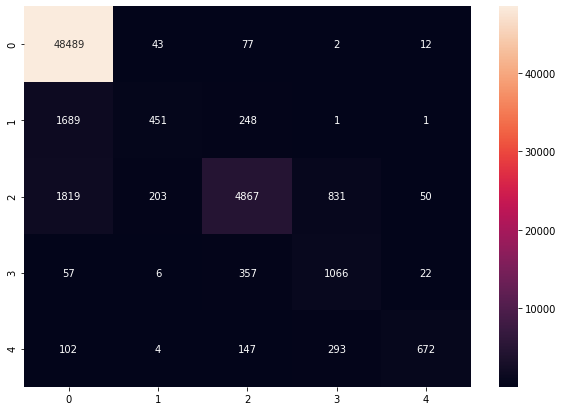

In [91]:
df_cm = pd.DataFrame(confusion_matrix(df.real, df.predicted), index = [i for i in "01234"],
                  columns = [i for i in "01234"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  fmt='g')